# Twitter Sentiment Analysis

#### import relevant dependant libraries

In [216]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import missingno as msno
import autoreload
import csv
import os
import sys

from collections import defaultdict, Counter

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

sb.set_style('darkgrid')
sb.set()

pd.set_option('display.max_column', 100)
pd.set_option('display.max_rows', 1000)

%matplotlib inline


#### Load Dataset from local machine

In [217]:
df = pd.read_csv("D:\Open Classroom\Datasets\Twitter Tweets Sentiment Dataset\Tweets.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


#### Statistical representation

In [218]:
df.shape

(27481, 4)

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [220]:
round(df.describe(), 2)

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,0b43df0462,Coffee in hand and sun shining in my window. ...,good,neutral
freq,1,1,199,11118


In [221]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

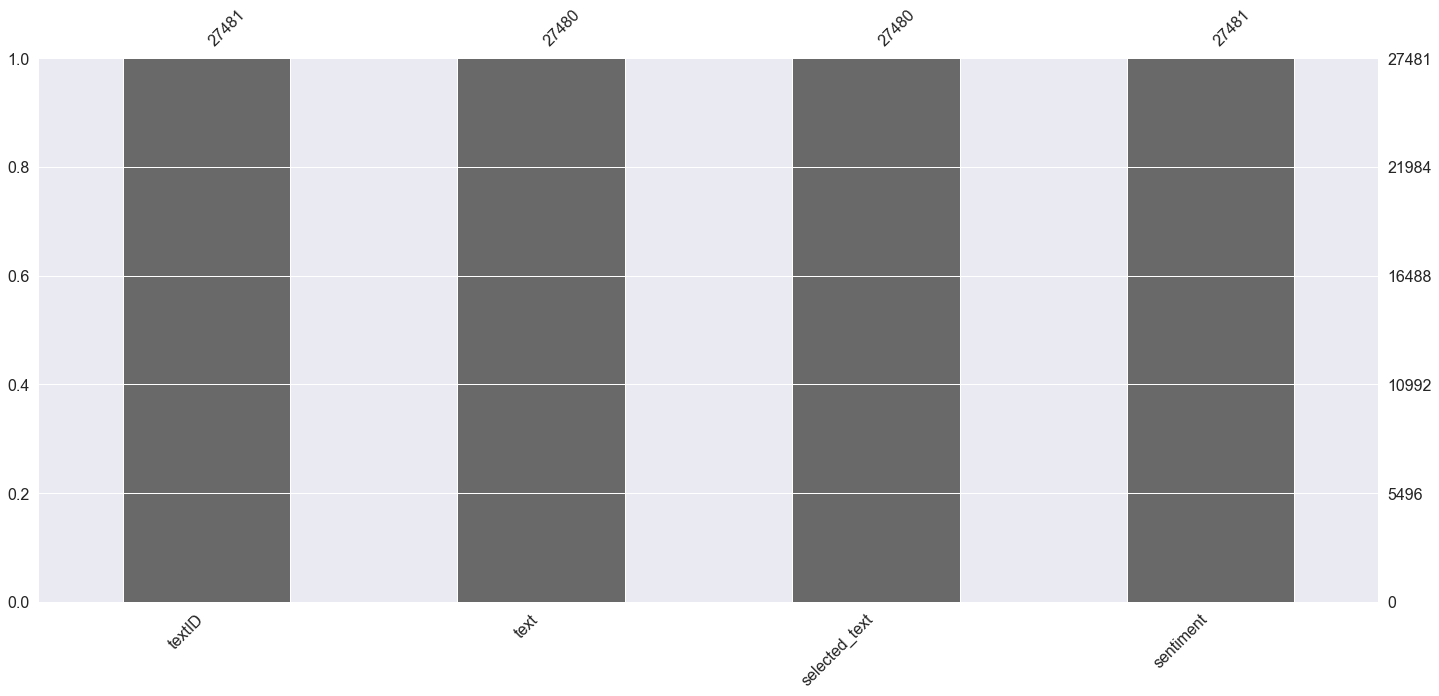

In [222]:
msno.bar(df)

### Exploratory Data Analysis

In [223]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [224]:
df.drop(columns = ['textID'], inplace = True)

In [225]:
df.isnull().sum()

df.dropna(axis = 'index', how = 'any', inplace = True)
df.isnull().sum()

text             0
selected_text    0
sentiment        0
dtype: int64

#### Data Preparation

In [226]:
le = LabelEncoder()

df['sentiment_num'] = le.fit_transform(df['sentiment'])
df.head()

,text,selected_text,sentiment,sentiment_num
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,my boss is bullying me...,bullying me,negative,0
3,what interview! leave me alone,leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


In [227]:
df.isnull().sum()

text             0
selected_text    0
sentiment        0
sentiment_num    0
dtype: int64

In [228]:
x = df['text']
y = df['sentiment_num']

%timeit x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

print('x train: ', x_train.shape)
print('x test: ', x_test.shape)
print('y train: ', y_train.shape)
print('y test: ', y_test.shape)

4.34 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
x train:  (21984,)
x test:  (5496,)
y train:  (21984,)
y test:  (5496,)


#### Vectorization

In [229]:
vect = CountVectorizer()

%timeit vect.fit(x_train)

554 ms ± 61.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [230]:
x_train_vect = vect.fit_transform(x_train) # Document Term Matrix
x_train_vect


<21984x23045 sparse matrix of type '<class 'numpy.int64'>'
	with 252019 stored elements in Compressed Sparse Row format>

x_train_vect has 21984 observations and 23045 tokens

In [231]:
x_test_vect = vect.fit_transform(x_test)
x_test_vect

<5496x9583 sparse matrix of type '<class 'numpy.int64'>'
	with 62786 stored elements in Compressed Sparse Row format>

x_test_vect has 5496 observations and 9583 tokens

#### Build and Evaluate Model

In [232]:
dtc = DecisionTreeClassifier()

dtc.fit(x_train_vect, y_train)

DecisionTreeClassifier()

In [233]:
x_train_vect_pred = dtc.predict(x_train_vect)
print(x_train_vect_pred)

[0 1 0 ... 2 0 0]


In [234]:
x_train_vect_pred_acc = accuracy_score(x_train_vect_pred, y_train)
x_train_vect_pred_acc * 100

99.92267103347889

In [235]:
prob_log = dtc.predict_proba(x_train_vect)
prob_log

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

#### Model Testing

In [236]:
def model_testing(text):
    tweet_df = {'Text': [text]}
    df = pd.DataFrame(tweet_df)
    test_df = df['Text']
    ohe = OneHotEncoder(handle_unknown='ignore')
    x_test_df = ohe.fit_transform(test_df)
    text_vect = vect.transform(x_test_df)
    text_predict = dtc.predict(text_vect)
    return text_predict

In [237]:
df['text'].loc[4]

' Sons of ****, why couldn`t they put them on the releases we already bought'

In [238]:
tweet = str(input()).title()
model_testing(tweet)

 why couldn`t they put them on the releases we already bought


ValueError: Expected 2D array, got 1D array instead:
array=['Why Couldn`T They Put Them On The Releases We Already Bought'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.